Total QSO pop. 54468
(10000, 1761)
[[2.5072434 4.8568683 1.7512105 ... 2.8478117 3.508848  3.1805766]
 [2.1635003 1.4898193 7.753005  ... 4.2962847 4.8341804 4.65798  ]]


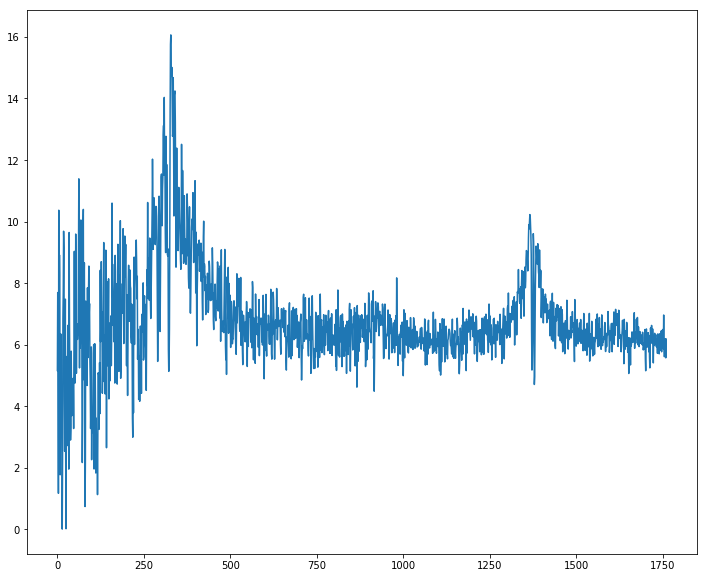

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob

def random_pick(N,k,seed):
  """
  Outputs a random list of k distinct indices out of a main list of indices of length N > k
  """
  output_lst = []
  L = list(range(N))
  np.random.seed(seed)
  for j in range(k):
    picked = int(np.random.rand()*(N-j))
    output_lst.append(L.pop(picked))

  return output_lst

# Get a full training set of spectra
train_size = 10000

all_ = glob.glob(r"..\data\BOSSLyaDR9_spectra\*\*.fits")
total_size = len(all_)
print("Total QSO pop.",total_size)
all_arr = np.array(all_)
sample = all_arr[random_pick(total_size,train_size,int(np.random.rand()*1000))]
zmin = 2.0
zmax = 3.5
X_lst = []
min_dimsize = 1e9

for s in sample:
    # Open current fits file
    hdu = fits.open(s)
    # Get spectrum data
    a = hdu[1].data
    loglam = a.LOGLAM
    z = 10**loglam/1216.-1
    cont = a.CONT
    f = a.FLUX
    # Retain non null continuum and z in selected range
    idx_z = np.array([[idx,zok] for idx,zok in enumerate(z) if (zok >= zmin and zok <= zmax)])
    z_r = idx_z[:,1]
    if (len(z_r) < min_dimsize) :
        min_dimsize = len(z_r)
    f_z = f[idx_z[:,0].astype(int)]
    f_z = f_z - np.min(f_z)
    #z_r = z_r[f_z > 0]
    #f_z = f_z[f_z > 0]
    #X_lst.append(z_r)
    X_lst.append(f_z)
    #print(idx_z[0,0],idx_z[-1,0])
    hdu.close()


for item in X_lst:
    item = item[:min_dimsize]
    
#flat_list = [item for sublist in X_lst for item in sublist]
#flat_arr = np.array(flat_list)
#print(flat_arr.shape)
X_train = np.array(X_lst)
#np.reshape(flat_arr,(train_size,min_dimsize))
print(X_train.shape)
print(X_train[:2,:])

np.savetxt('boss_spectra.txt',X_train)

picked = int(np.random.rand()*train_size)
plt.figure(figsize=(12,10))
plt.plot(X_train[picked])
plt.show()

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
#from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

n = min_dimsize

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100

# Load MNIST data
#(X_train, y_train), (X_test, y_test) = mnist.load_data()
#X_train = (X_train.astype(np.float32) - 127.5)/127.5
#X_train = X_train.reshape(60000, 784)

# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

generator = Sequential()
generator.add(Dense(256, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(n, activation='relu'))
generator.compile(loss='mse', optimizer=adam)

discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=n, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('../plot/gan_loss_BOSS_epoch_%d.png' % epoch)

# Create a wall of generated  images
def plotGeneratedImages(epoch, examples=3, dim=(2, 2), figsize=(12, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.plot(generatedImages[i],)
        plt.axis('off')
    plt.subplot(dim[0], dim[1],examples+1)
    plt.plot(np.mean(generator.predict(np.random.normal(0, 1, size=[100, randomDim])),axis=0))
    plt.axis('off')
    plt.title("Mean at epoch "+ str(epoch))
    plt.tight_layout()
    plt.savefig('../plot/gan_generated_image_BOSS_epoch_%d.png' % epoch)
    plt.close('all')

    
    
# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('./gan_generator_BOSS_epoch_%d.h5' % epoch)
    discriminator.save('./gan_discriminator_BOSS_epoch_%d.h5' % epoch)

def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] // batchSize
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)

    plotGeneratedImages(0)
    
    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]
            #print(imageBatch.shape)
            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            #print(generatedImages.shape)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 2 == 0 or e == 0:
            plotGeneratedImages(e)
            saveModels(e)

    # Plot losses from every epoch
    plotLoss(e)

if __name__ == '__main__':
    train(200, 100)

Epochs: 200
Batch size: 100
Batches per epoch: 100
[0.02632488 0.04050024 0.         ... 0.05434535 0.         0.        ]
--------------- Epoch 1 ---------------
[0.         0.30644467 0.09714874 ... 0.00824534 0.         0.23669471]
--------------- Epoch 2 ---------------
[0.         0.29434192 0.60869205 ... 0.         0.         0.30257794]
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
[0.         0.54562616 0.         ... 0.30853915 0.9511243  0.6611331 ]
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
[2.5651898 1.7667404 4.0421977 ... 2.5652297 1.3889105 3.6906517]
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
[9.971969 8.844725 9.640103 ... 4.655467 5.354607 6.520105]
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------
[3.1103523 3.852103  2.3674443 ... 3.2252069 2.1438463 2.3341012]
--------------- Epoch 11 ---------------
--------------- Epoch 12 --

--------------- Epoch 109 ---------------
--------------- Epoch 110 ---------------
[3.8687842 7.7701063 5.544224  ... 1.3719292 2.0737383 1.8067137]
--------------- Epoch 111 ---------------
--------------- Epoch 112 ---------------
[3.1234798 2.8986807 4.569632  ... 4.6222754 3.1514928 4.5936294]
--------------- Epoch 113 ---------------
--------------- Epoch 114 ---------------
[3.7622771 3.5152173 2.9656155 ... 1.6865749 4.0116277 3.3524117]
--------------- Epoch 115 ---------------
--------------- Epoch 116 ---------------
[ 9.734567  11.843827   9.986564  ...  7.624005  10.755138   7.0560794]
--------------- Epoch 117 ---------------
--------------- Epoch 118 ---------------
[5.4233975 4.755781  2.908525  ... 7.4419675 6.428961  8.096959 ]
--------------- Epoch 119 ---------------
--------------- Epoch 120 ---------------
[3.9201674 9.691029  3.3425012 ... 1.0676918 4.308701  7.744202 ]
--------------- Epoch 121 ---------------
--------------- Epoch 122 ---------------
[14.503929